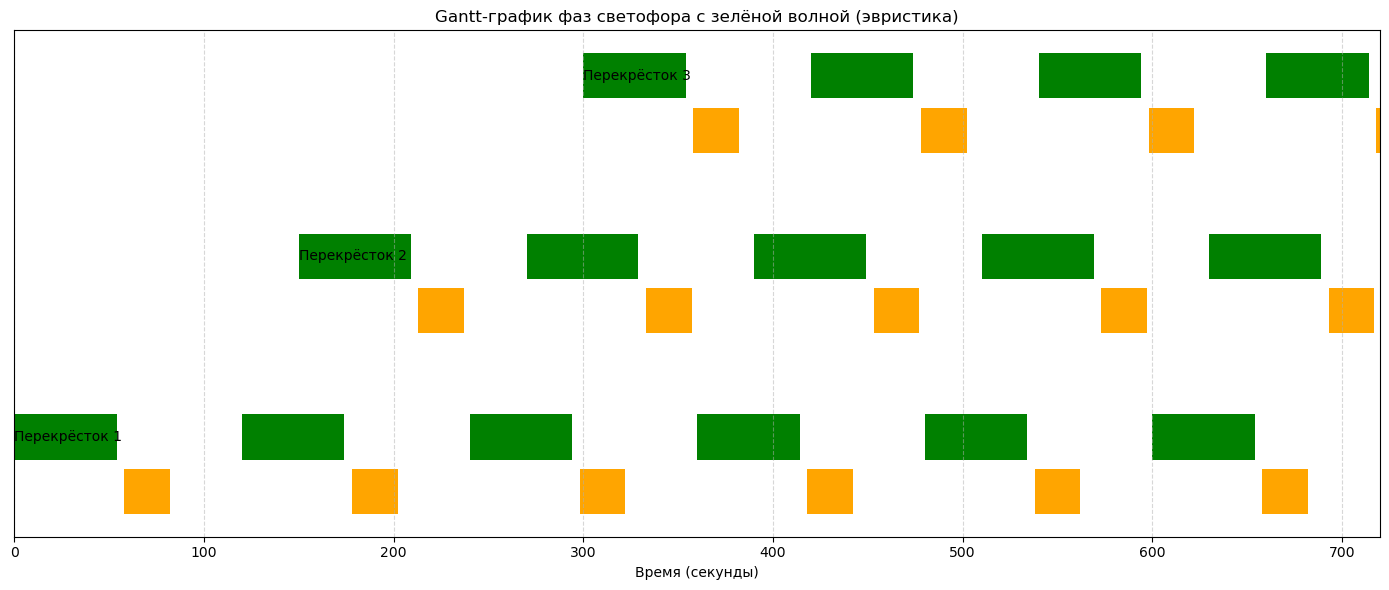

Общая задержка: 657,369.6 усл. ед.
Задержка автобусов: 35,059.8 машино-секунд
Задержка пешеходов (прибл.): 962.0 сек. (на всех перекрёстках за цикл)
Средняя задержка одного потока, проходящего через 3 перекрёстка: 58.4 сек.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

# Загрузка данных (файлы из твоего проекта)
signals_df = pd.read_csv("signals_current.csv")
with open("constraints.json") as f:
    constraints = json.load(f)
flows = pd.read_csv("flows_peak.csv")

NUM_INTERSECTIONS = 3
TRAVEL_TIME = 30  # секунд между перекрёстками
CYCLE = 120
LOST = 2 * constraints['lost_time_sec_per_phase']
PEDESTRIAN_MAIN = max(constraints['pedestrian_green_sec'], 20)
PEDESTRIAN_SEC = max(constraints['pedestrian_green_sec'], 10)

# Генерация эвристического решения
solution = []
plan_after = {}
time_accum = 0
for i in range(NUM_INTERSECTIONS):
    df = flows[flows.intersection_id == (i+1)]
    main_flow = df[df.approach.isin(['N','S'])]['intensity_veh_per_hr'].sum()
    sec_flow = df[df.approach.isin(['E','W'])]['intensity_veh_per_hr'].sum()
    main_bus_share = df[df.approach.isin(['N','S'])]['bus_share'].mean()

    if main_flow >= sec_flow:
        g_main = int(CYCLE * 0.45)
        g_sec = int(CYCLE * 0.20)
    else:
        g_main = int(CYCLE * 0.20)
        g_sec = int(CYCLE * 0.45)

    # Приоритет для автобусов
    if main_bus_share > 0.1:
        g_main += 5

    g_main = max(g_main, PEDESTRIAN_MAIN, constraints['min_green_sec'])
    g_sec = max(g_sec, PEDESTRIAN_SEC, constraints['min_green_sec'])

    # Не превышаем цикл
    if g_main + g_sec + LOST > CYCLE:
        diff = (g_main + g_sec + LOST) - CYCLE
        if g_sec - diff > PEDESTRIAN_SEC:
            g_sec -= diff
        else:
            g_main -= diff

    offset = (i * TRAVEL_TIME) % CYCLE
    solution.extend([CYCLE, g_main, g_sec, offset])

    abs_offset = time_accum + offset
    plan_after[i + 1] = {
        "cycle": CYCLE,
        "main": g_main,
        "sec": g_sec,
        "offset": offset,
        "abs_offset": abs_offset
    }
    time_accum += CYCLE

# Визуализация
plot_duration = sum(p['cycle'] for p in plan_after.values()) * 2

fig, ax = plt.subplots(figsize=(14, 6))
colors = {"main": "green", "sec": "orange"}

# Для расчёта зелёной волны
time_accumulated = 0
time_accums = []
for i in range(1, NUM_INTERSECTIONS + 1):
    if i == 1:
        time_accumulated = 0
    else:
        time_accumulated += plan_after[i - 1]['cycle']
    time_accums.append(time_accumulated)

for i, (inter_id, plan) in enumerate(plan_after.items(), start=1):
    y_main = i * 2
    y_sec = i * 2 - 0.6

    cycle = plan['cycle']
    main_dur = plan['main']
    sec_dur = plan['sec']
    lost_time = constraints['lost_time_sec_per_phase']
    abs_offset = plan['abs_offset']

    # Главная фаза (несколько повторов)
    k = 0
    while True:
        start = abs_offset + k * cycle
        if start > plot_duration:
            break
        ax.broken_barh([(start, main_dur)], (y_main, 0.5), facecolors=colors['main'])
        k += 1

    # Второстепенная фаза (несколько повторов)
    k = 0
    while True:
        start = abs_offset + main_dur + lost_time + k * cycle
        if start > plot_duration:
            break
        ax.broken_barh([(start, sec_dur)], (y_sec, 0.5), facecolors=colors['sec'])
        k += 1

    

    ax.text(abs_offset, y_main + 0.25, f"Перекрёсток {inter_id}", va="center")

ax.set_xlim(0, plot_duration)
ax.set_yticks([])
ax.set_xlabel("Время (секунды)")
ax.set_title("Gantt-график фаз светофора с зелёной волной (эвристика)")
ax.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
def analyze_delays(solution, flows, constraints, NUM_INTERSECTIONS, GENE_SIZE=4):
    total_delay = 0.0
    bus_delay = 0.0
    ped_delay = 0.0
    lost = 2 * constraints['lost_time_sec_per_phase']
    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = solution[base:base+GENE_SIZE]
        df = flows[flows.intersection_id == (i+1)]
        for _, row in df.iterrows():
            is_main = row.approach in ('N', 'S')
            flow = row.intensity_veh_per_hr
            bus_share = row.bus_share
            flow_bus = flow * bus_share
            green = g_main if is_main else g_sec
            bonus = constraints['min_extra_green_sec']
            eff_green = min(cycle, green + bonus)
            weight = 1 + 2 * bus_share  # приоритет для автобусов

            total_delay += (cycle - eff_green) * flow * weight
            bus_delay += (cycle - eff_green) * flow_bus
            # Для пешеходов: задержка – разница между циклом и реально выделенным зелёным временем
            ped_required = constraints['pedestrian_green_sec']
            if green > ped_required:
                ped_delay += (cycle - green)  # суммируем лишнее ожидание, если фаза длиннее минимума

    return total_delay, bus_delay, ped_delay

# Вызов функции
total, buses, peds = analyze_delays(solution, flows, constraints, NUM_INTERSECTIONS)
print(f"Общая задержка: {total:,.1f} усл. ед.")
print(f"Задержка автобусов: {buses:,.1f} машино-секунд")
print(f"Задержка пешеходов (прибл.): {peds:,.1f} сек. (на всех перекрёстках за цикл)")
import numpy as np

TRAVEL_TIME = 30  # секунд между перекрёстками

def get_green_window(offset, cycle, green, lost_time):
    # Возвращает начало и конец зелёной фазы (N/S)
    start = offset
    end = offset + green
    return start, end

def wait_time_at_intersection(arrival, offset, cycle, green, lost_time):
    t_in_cycle = (arrival - offset) % cycle
    if 0 <= t_in_cycle < green:
        return 0  # Попал на зелёный, не ждёт
    else:
        # Сколько осталось до следующего зелёного
        to_next_green = (cycle - t_in_cycle) % cycle
        return to_next_green

def simulate_trip(plan_after, TRAVEL_TIME):
    times = []
    t = 0  # Начальное время (можно усреднять по всем фазам)
    for i in range(1, len(plan_after)+1):
        plan = plan_after[i]
        cycle = plan["cycle"]
        main = plan["main"]
        offset = plan["abs_offset"]
        lost_time = constraints['lost_time_sec_per_phase']
        wait = wait_time_at_intersection(t, offset, cycle, main, lost_time)
        t = t + wait  # ждём если надо
        times.append((i, t))  # отметим время въезда
        t = t + main + lost_time  # время выезда после завершения главной фазы (или минимально разрешённое)
        if i < len(plan_after):
            t = t + TRAVEL_TIME
    return times

# Теперь считаем задержку
delays = []
num_trials = 100  # усреднить по разным стартам (0..cycle)
cycle = plan_after[1]["cycle"]
for t0 in np.linspace(0, cycle, num_trials):
    t = t0
    delay = 0
    for i in range(1, NUM_INTERSECTIONS+1):
        plan = plan_after[i]
        c = plan["cycle"]
        main = plan["main"]
        offset = plan["abs_offset"]
        lost_time = constraints['lost_time_sec_per_phase']
        t_in_cycle = (t - offset) % c
        if 0 <= t_in_cycle < main:
            wt = 0
        else:
            wt = (c - t_in_cycle) % c
        delay += wt
        t += wt + main + lost_time
        if i < NUM_INTERSECTIONS:
            t += TRAVEL_TIME
    delays.append(delay)

avg_delay = np.mean(delays)
print(f"Средняя задержка одного потока, проходящего через 3 перекрёстка: {avg_delay:.1f} сек.")


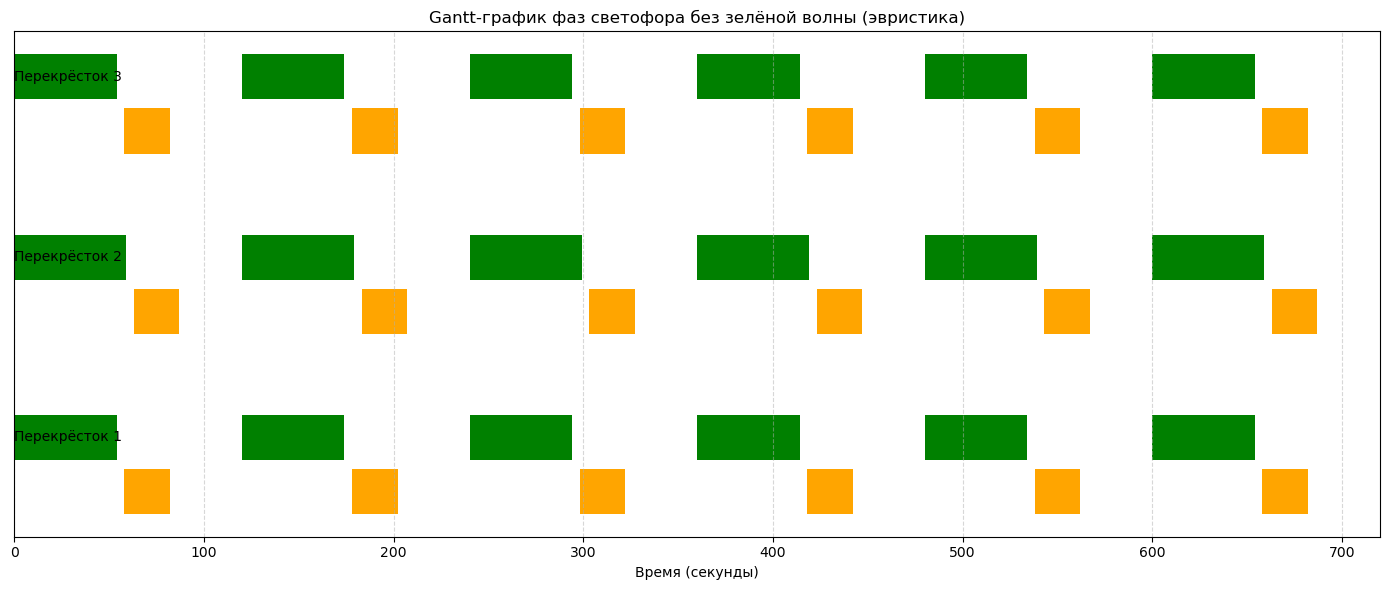

Общая задержка: 657,369.6 усл. ед.
Задержка автобусов: 35,059.8 машино-секунд
Задержка пешеходов (прибл.): 962.0 сек. (на всех перекрёстках за цикл)
Средняя задержка одного потока, проходящего через 3 перекрёстка: 65.0 сек.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

# Загрузка данных
signals_df = pd.read_csv("signals_current.csv")
with open("constraints.json") as f:
    constraints = json.load(f)
flows = pd.read_csv("flows_peak.csv")

NUM_INTERSECTIONS = 3
CYCLE = 120
LOST = 2 * constraints['lost_time_sec_per_phase']
PEDESTRIAN_MAIN = max(constraints['pedestrian_green_sec'], 20)
PEDESTRIAN_SEC = max(constraints['pedestrian_green_sec'], 10)

# Генерация эвристического решения без координации/зеленой волны
solution = []
plan_after = {}
for i in range(NUM_INTERSECTIONS):
    df = flows[flows.intersection_id == (i+1)]
    main_flow = df[df.approach.isin(['N','S'])]['intensity_veh_per_hr'].sum()
    sec_flow = df[df.approach.isin(['E','W'])]['intensity_veh_per_hr'].sum()
    main_bus_share = df[df.approach.isin(['N','S'])]['bus_share'].mean()

    if main_flow >= sec_flow:
        g_main = int(CYCLE * 0.45)
        g_sec = int(CYCLE * 0.20)
    else:
        g_main = int(CYCLE * 0.20)
        g_sec = int(CYCLE * 0.45)

    # Приоритет для автобусов
    if main_bus_share > 0.1:
        g_main += 5

    g_main = max(g_main, PEDESTRIAN_MAIN, constraints['min_green_sec'])
    g_sec = max(g_sec, PEDESTRIAN_SEC, constraints['min_green_sec'])

    # Не превышаем цикл
    if g_main + g_sec + LOST > CYCLE:
        diff = (g_main + g_sec + LOST) - CYCLE
        if g_sec - diff > PEDESTRIAN_SEC:
            g_sec -= diff
        else:
            g_main -= diff

    offset = 0  # Все стартуют одновременно, чтобы не было волны
    solution.extend([CYCLE, g_main, g_sec, offset])

    plan_after[i + 1] = {
        "cycle": CYCLE,
        "main": g_main,
        "sec": g_sec,
        "offset": offset,
        "abs_offset": offset
    }

# Визуализация
plot_duration = sum(p['cycle'] for p in plan_after.values()) * 2

fig, ax = plt.subplots(figsize=(14, 6))
colors = {"main": "green", "sec": "orange"}

for i, (inter_id, plan) in enumerate(plan_after.items(), start=1):
    y_main = i * 2
    y_sec = i * 2 - 0.6

    cycle = plan['cycle']
    main_dur = plan['main']
    sec_dur = plan['sec']
    lost_time = constraints['lost_time_sec_per_phase']
    abs_offset = plan['abs_offset']

    # Главная фаза (несколько повторов)
    k = 0
    while True:
        start = abs_offset + k * cycle
        if start > plot_duration:
            break
        ax.broken_barh([(start, main_dur)], (y_main, 0.5), facecolors=colors['main'])
        k += 1

    # Второстепенная фаза (несколько повторов)
    k = 0
    while True:
        start = abs_offset + main_dur + lost_time + k * cycle
        if start > plot_duration:
            break
        ax.broken_barh([(start, sec_dur)], (y_sec, 0.5), facecolors=colors['sec'])
        k += 1

    ax.text(abs_offset, y_main + 0.25, f"Перекрёсток {inter_id}", va="center")

ax.set_xlim(0, plot_duration)
ax.set_yticks([])
ax.set_xlabel("Время (секунды)")
ax.set_title("Gantt-график фаз светофора без зелёной волны (эвристика)")
ax.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Анализ задержек для эвристического решения
def analyze_delays(solution, flows, constraints, NUM_INTERSECTIONS, GENE_SIZE=4):
    total_delay = 0.0
    bus_delay = 0.0
    ped_delay = 0.0
    lost = 2 * constraints['lost_time_sec_per_phase']
    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = solution[base:base+GENE_SIZE]
        df = flows[flows.intersection_id == (i+1)]
        for _, row in df.iterrows():
            is_main = row.approach in ('N', 'S')
            flow = row.intensity_veh_per_hr
            bus_share = row.bus_share
            flow_bus = flow * bus_share
            green = g_main if is_main else g_sec
            bonus = constraints['min_extra_green_sec']
            eff_green = min(cycle, green + bonus)
            weight = 1 + 2 * bus_share  # приоритет для автобусов

            total_delay += (cycle - eff_green) * flow * weight
            bus_delay += (cycle - eff_green) * flow_bus
            # Для пешеходов: задержка – разница между циклом и реально выделенным зелёным временем
            ped_required = constraints['pedestrian_green_sec']
            if green > ped_required:
                ped_delay += (cycle - green)  # суммируем лишнее ожидание, если фаза длиннее минимума

    return total_delay, bus_delay, ped_delay

# Вызов функции
total, buses, peds = analyze_delays(solution, flows, constraints, NUM_INTERSECTIONS)
print(f"Общая задержка: {total:,.1f} усл. ед.")
print(f"Задержка автобусов: {buses:,.1f} машино-секунд")
print(f"Задержка пешеходов (прибл.): {peds:,.1f} сек. (на всех перекрёстках за цикл)")
import numpy as np

TRAVEL_TIME = 30  # секунд между перекрёстками

def get_green_window(offset, cycle, green, lost_time):
    # Возвращает начало и конец зелёной фазы (N/S)
    start = offset
    end = offset + green
    return start, end

def wait_time_at_intersection(arrival, offset, cycle, green, lost_time):
    t_in_cycle = (arrival - offset) % cycle
    if 0 <= t_in_cycle < green:
        return 0  # Попал на зелёный, не ждёт
    else:
        # Сколько осталось до следующего зелёного
        to_next_green = (cycle - t_in_cycle) % cycle
        return to_next_green

def simulate_trip(plan_after, TRAVEL_TIME):
    times = []
    t = 0  # Начальное время (можно усреднять по всем фазам)
    for i in range(1, len(plan_after)+1):
        plan = plan_after[i]
        cycle = plan["cycle"]
        main = plan["main"]
        offset = plan["abs_offset"]
        lost_time = constraints['lost_time_sec_per_phase']
        wait = wait_time_at_intersection(t, offset, cycle, main, lost_time)
        t = t + wait  # ждём если надо
        times.append((i, t))  # отметим время въезда
        t = t + main + lost_time  # время выезда после завершения главной фазы (или минимально разрешённое)
        if i < len(plan_after):
            t = t + TRAVEL_TIME
    return times

# Теперь считаем задержку
delays = []
num_trials = 100  # усреднить по разным стартам (0..cycle)
cycle = plan_after[1]["cycle"]
for t0 in np.linspace(0, cycle, num_trials):
    t = t0
    delay = 0
    for i in range(1, NUM_INTERSECTIONS+1):
        plan = plan_after[i]
        c = plan["cycle"]
        main = plan["main"]
        offset = plan["abs_offset"]
        lost_time = constraints['lost_time_sec_per_phase']
        t_in_cycle = (t - offset) % c
        if 0 <= t_in_cycle < main:
            wt = 0
        else:
            wt = (c - t_in_cycle) % c
        delay += wt
        t += wt + main + lost_time
        if i < NUM_INTERSECTIONS:
            t += TRAVEL_TIME
    delays.append(delay)

avg_delay = np.mean(delays)
print(f"Средняя задержка одного потока, проходящего через 3 перекрёстка: {avg_delay:.1f} сек.")
